In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import RFE
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv(r"C:\Users\nagam\Downloads\diamonds - diamonds.csv")
print("✅ Dataset loaded successfully.")

✅ Dataset loaded successfully.


In [9]:
print(f"Shape: {df.shape}")

Shape: (53940, 10)


In [11]:
pd.set_option('display.max_columns', None)

In [13]:
print("\n First 5 rows:")
print(df.head())


 First 5 rows:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


In [15]:
print("\n Dataset Info:")
print(df.info())


 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None


In [17]:
print("\n Statistical Summary:")
print(df.describe())


 Statistical Summary:
              carat         depth         table         price             x  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184   3932.799722      5.731157   
std        0.474011      1.432621      2.234491   3989.439738      1.121761   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    950.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5324.250000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53940.000000  53940.000000  
mean       5.734526      3.538734  
std        1.142135      0.705699  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.

In [19]:
print("\n Missing Values:")
print(df.isnull().sum())


 Missing Values:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


In [21]:
df.dropna(inplace=True)
print(f"\n✅ After dropping nulls: {df.shape}")


✅ After dropping nulls: (53940, 10)


In [23]:
#OUTLIER REMOVAL USING IQR METHOD

print("\nRemoving Outliers...")
numeric_cols = ['carat', 'price', 'x', 'y', 'z']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    before = len(df)
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    after = len(df)
    print(f"  {col}: Removed {before - after} outliers")

print(f" After outlier removal: {df.shape}")


Removing Outliers...
  carat: Removed 1889 outliers
  price: Removed 2535 outliers
  x: Removed 5 outliers
  y: Removed 1 outliers
  z: Removed 9 outliers
 After outlier removal: (49501, 10)


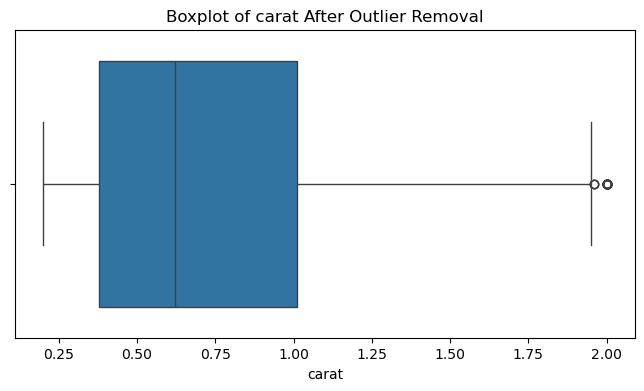

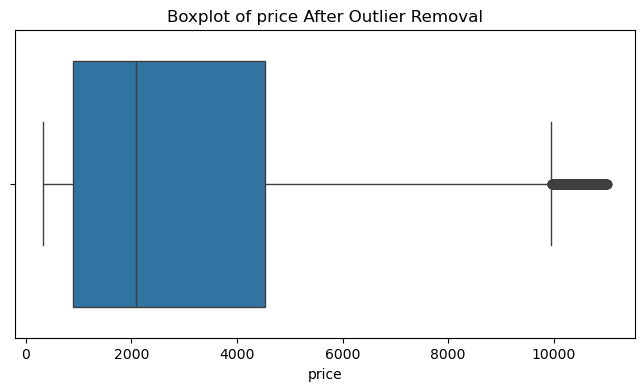

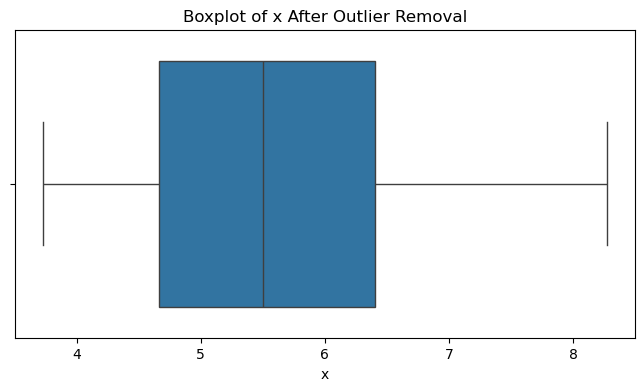

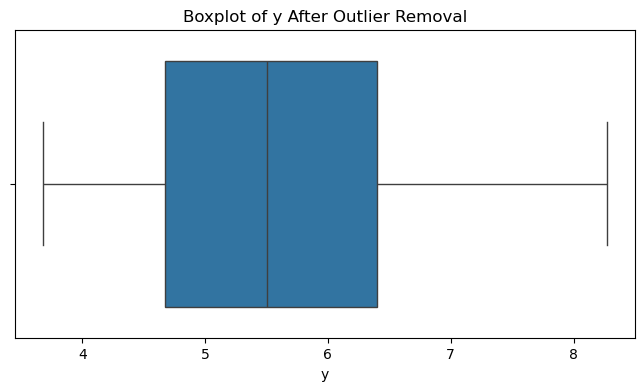

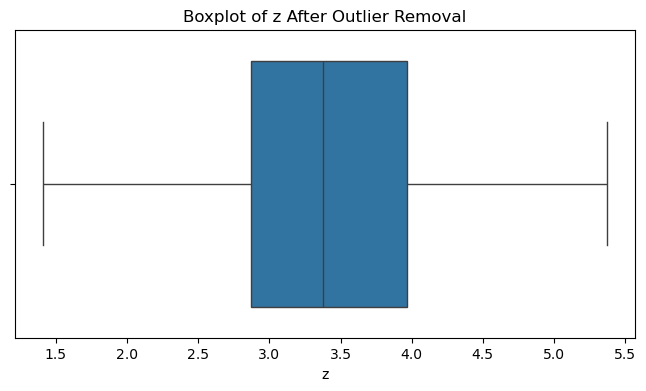

In [25]:
# Visual check for outliers after removal
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col} After Outlier Removal')
    plt.show()

In [27]:
# Remove invalid zeros for dimension variables

for col in ['x', 'y', 'z']:
    before = len(df)
    df = df[df[col] > 0]
    after = len(df)
    if before != after:
        print(f"  Removed {before - after} rows with zero {col}")

print(f" After removing zero dimensions: {df.shape}")

 After removing zero dimensions: (49501, 10)


STEP 2: CATEGORICAL ENCODING AND SKEWNESS HANDLING

In [29]:
print("\n🔧 Encoding Categorical Variables...")

cat_features = ['cut', 'color', 'clarity']

# ✅ ENCODE FIRST (before log transformation)
encoder = OrdinalEncoder(categories=[
    ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
    ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
])

df[cat_features] = encoder.fit_transform(df[cat_features])
print("✅ Categorical encoding complete")


🔧 Encoding Categorical Variables...
✅ Categorical encoding complete


In [32]:
# Save encoder
os.makedirs('models', exist_ok=True)
with open('models/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
print("✅ Encoder saved")

✅ Encoder saved


In [34]:
# Handle skewness using log transformation
print("\n🔧 Applying Log Transformation for Skewness...")
for col in ['carat', 'x', 'y', 'z', 'price']:
    df[col] = np.log1p(df[col])
    print(f"  Log transformed: {col}")

print("✅ Log transformation complete")


🔧 Applying Log Transformation for Skewness...
  Log transformed: carat
  Log transformed: x
  Log transformed: y
  Log transformed: z
  Log transformed: price
✅ Log transformation complete


STEP 3: FEATURE ENGINEERING

In [37]:
# Convert price to INR
usd_to_inr = 83.0
df['price_inr'] = df['price'] * usd_to_inr
print("✅ Price converted to INR")

✅ Price converted to INR


In [39]:
# Calculate Volume
df['Volume'] = df['x'] * df['y'] * df['z']
print(" Volume created")

 Volume created


In [41]:
# Calculate Price per Carat
df['PricePerCarat'] = df['price'] / df['carat']
print("PricePerCarat created")

PricePerCarat created


In [43]:
#SAVE MEAN PRICEPERCARAT
mean_price_per_carat = df['PricePerCarat'].mean()
with open('models/mean_price_per_carat.pkl', 'wb') as f:
    pickle.dump(mean_price_per_carat, f)
print(f"Mean PricePerCarat saved: {mean_price_per_carat:.4f}")

Mean PricePerCarat saved: 16.8115


In [45]:
# Calculate Dimension Ratio
df['DimensionRatio'] = (df['x'] + df['y']) / (2 * df['z'])
print("DimensionRatio created")

DimensionRatio created


In [47]:

# Create Carat Category
def carat_category(carat_log_value):
    carat_original = np.expm1(carat_log_value)
    if carat_original < 0.5:
        return 'Light'
    elif 0.5 <= carat_original <= 1.5:
        return 'Medium'
    else:
        return 'Heavy'

df['CaratCategory'] = df['carat'].apply(carat_category)
print("CaratCategory created")

CaratCategory created


In [49]:
print(f"Shape: {df.shape}")

Shape: (49501, 15)


In [51]:

df.columns.tolist()

['carat',
 'cut',
 'color',
 'clarity',
 'depth',
 'table',
 'price',
 'x',
 'y',
 'z',
 'price_inr',
 'Volume',
 'PricePerCarat',
 'DimensionRatio',
 'CaratCategory']

In [53]:
# Set seaborn style for aesthetics
sns.set(style="whitegrid")

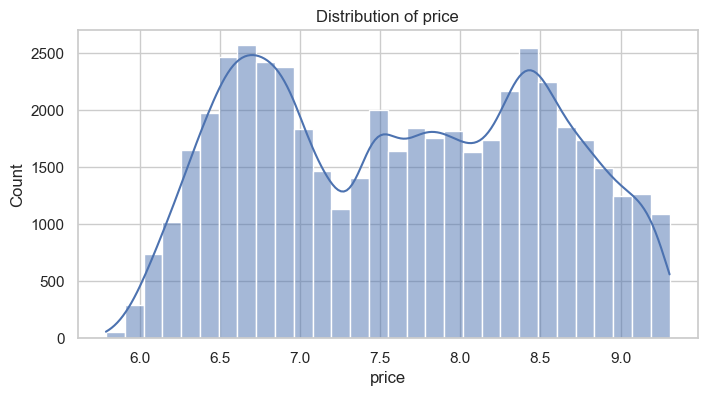

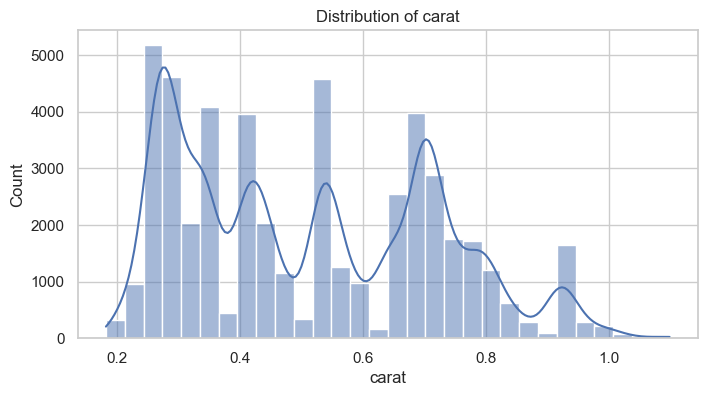

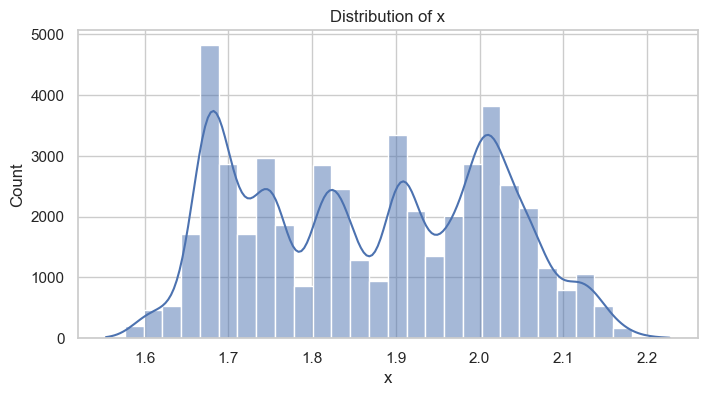

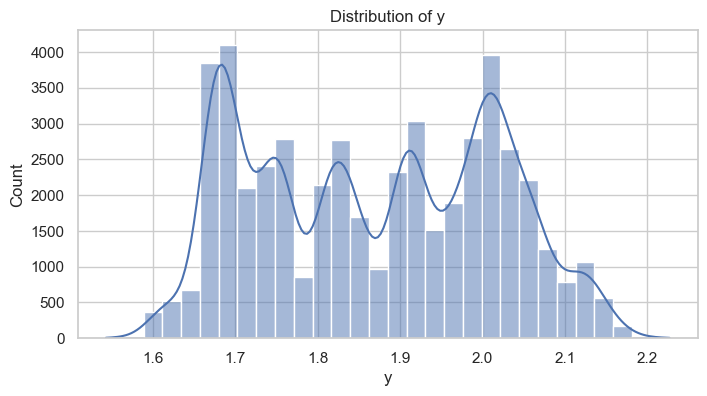

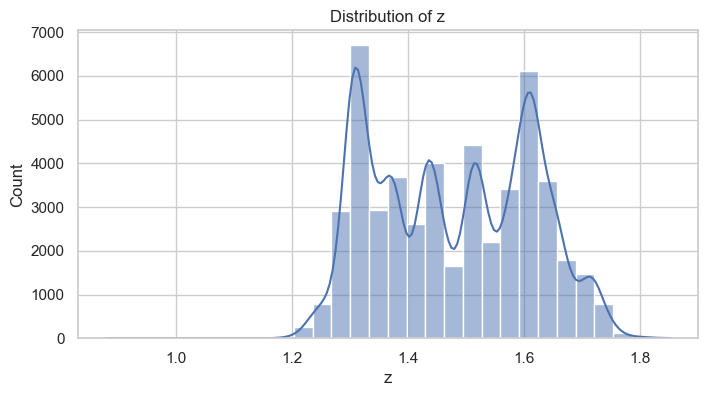

In [55]:
# 1. Distribution plots for price, carat, x, y, z
numeric_cols = ['price', 'carat', 'x', 'y', 'z']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

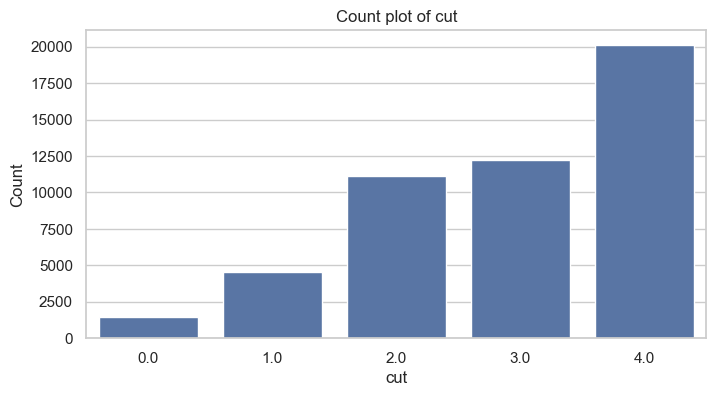

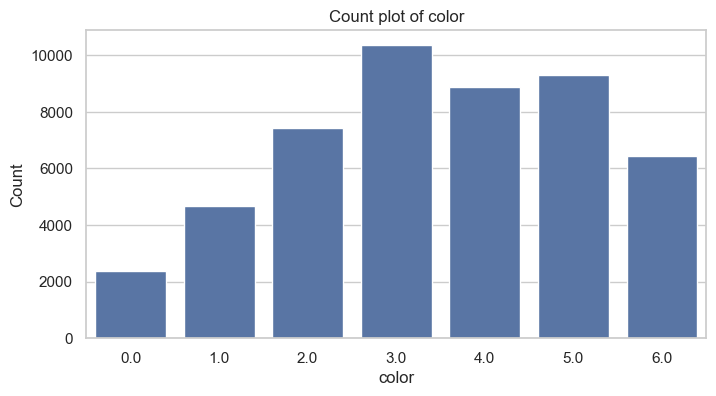

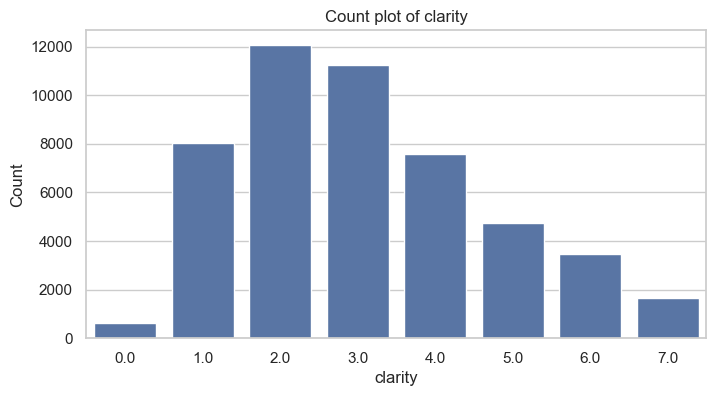

In [57]:
# 2. Count plots for categorical features (cut, color, clarity)
categorical_cols = ['cut', 'color', 'clarity']
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df, order=sorted(df[col].unique()))
    plt.title(f'Count plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()
    

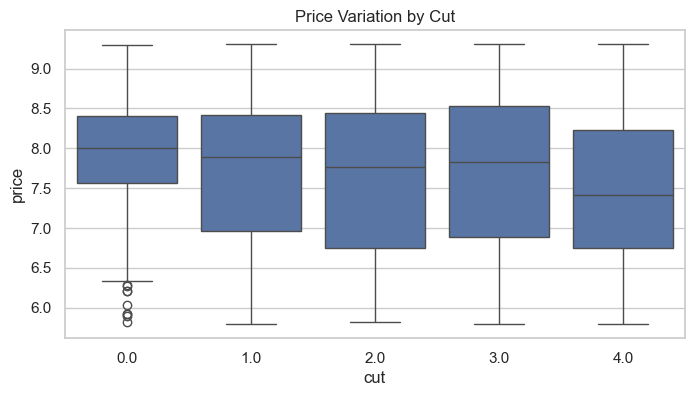

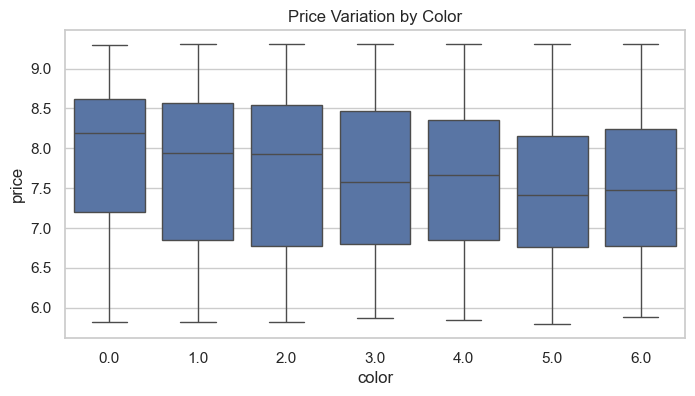

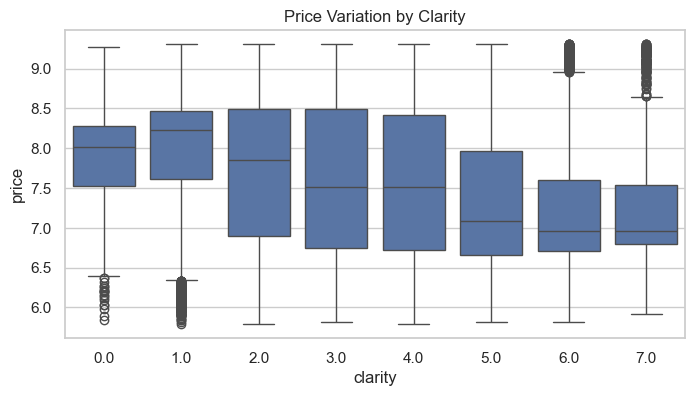

In [59]:
# 3. Price variation with carat, cut, color, clarity using boxplots
plt.figure(figsize=(8, 4))
sns.boxplot(x='cut', y='price', data=df)
plt.title('Price Variation by Cut')
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='color', y='price', data=df)
plt.title('Price Variation by Color')
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='clarity', y='price', data=df)
plt.title('Price Variation by Clarity')
plt.show()

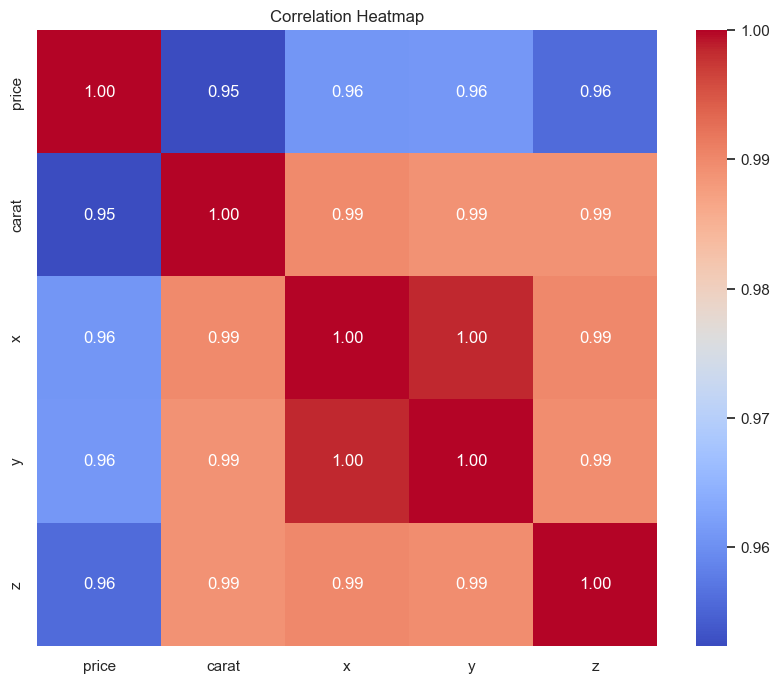

In [61]:
# 4. Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

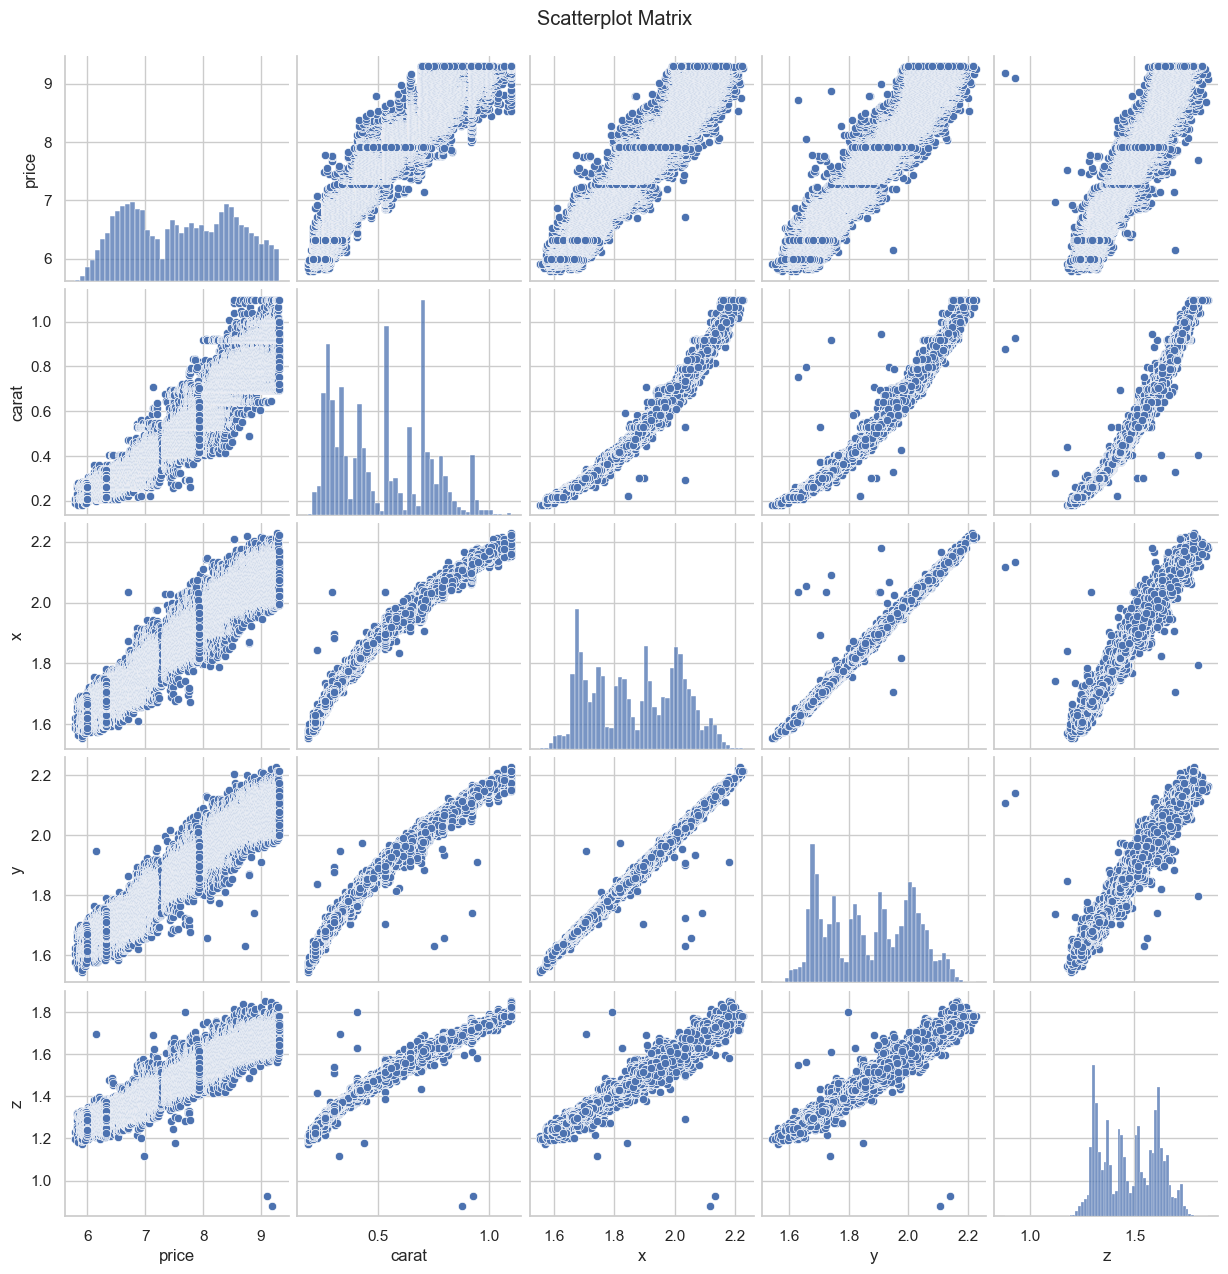

In [63]:
# 5. Scatterplot matrix for carat, x, y, z, and price
sns.pairplot(df[numeric_cols])
plt.suptitle("Scatterplot Matrix", y=1.02)
plt.show()

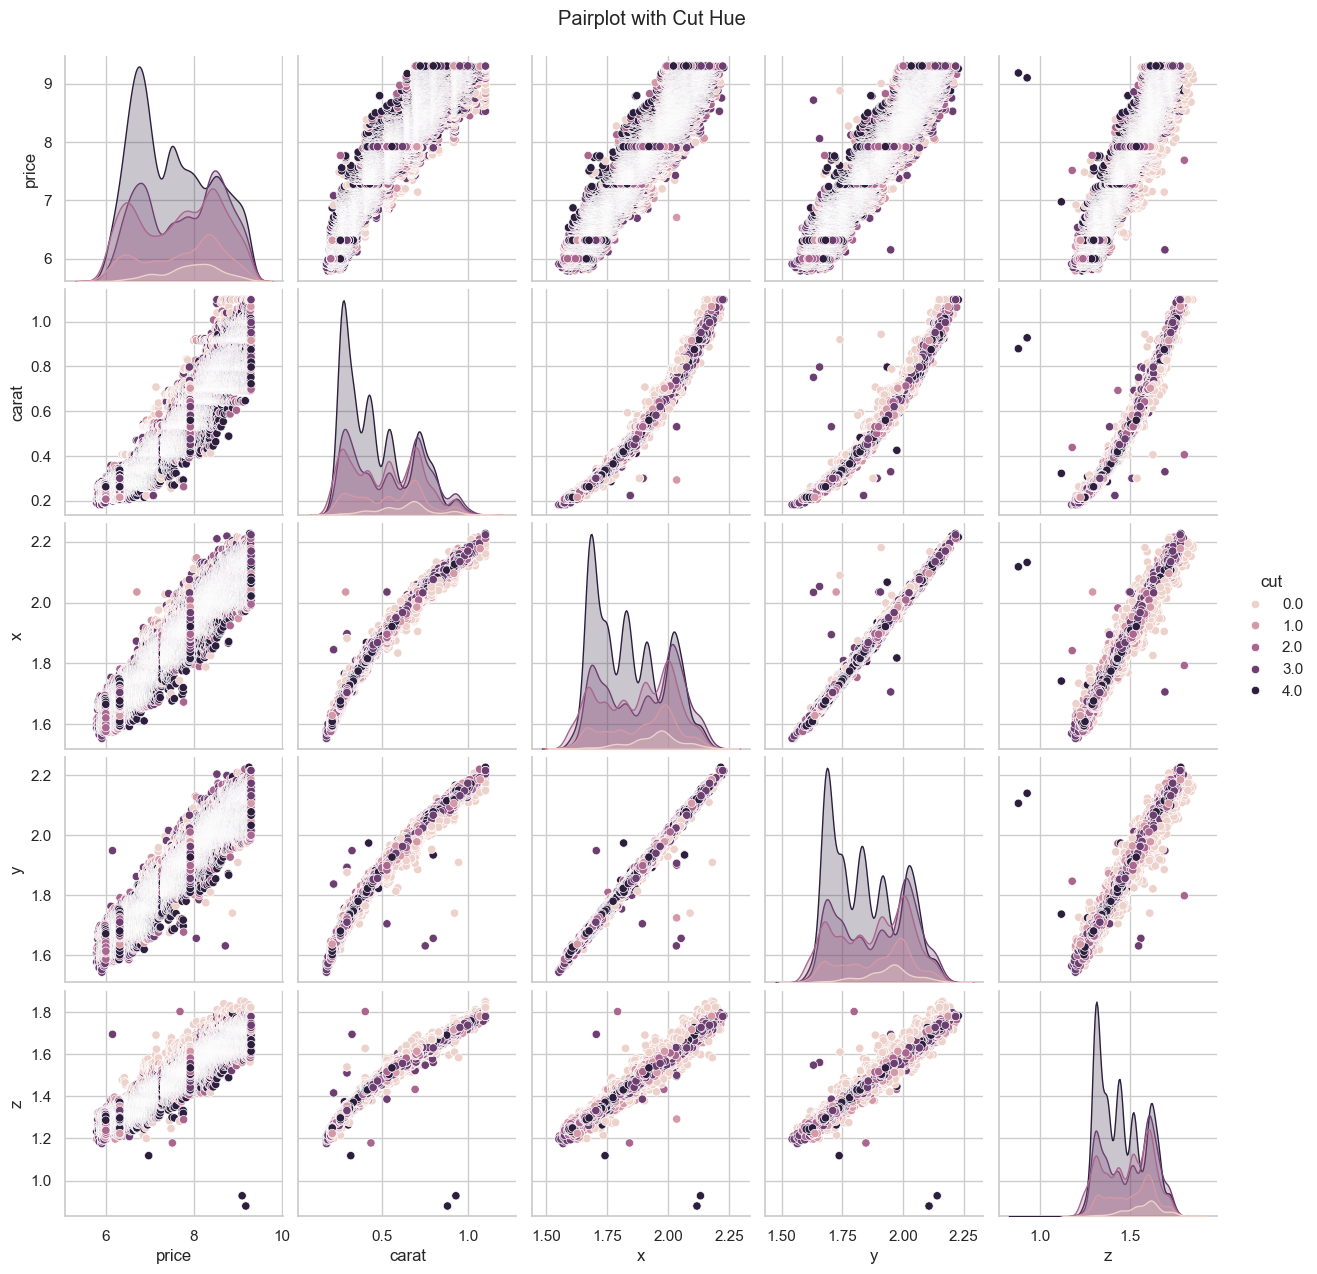

In [66]:
# 6. Pairwise relationships using sns.pairplot()
# (Same as previous step, can add hue for categoricals if desired)
sns.pairplot(df[numeric_cols + ['cut']], hue='cut')
plt.suptitle("Pairplot with Cut Hue", y=1.02)
plt.show()

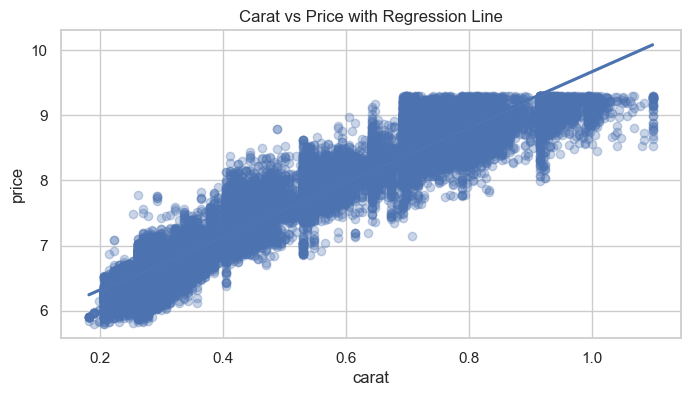

In [67]:
# 7. Carat vs. Price regression lineplot
plt.figure(figsize=(8, 4))
sns.regplot(x='carat', y='price', data=df, scatter_kws={'alpha':0.3})
plt.title('Carat vs Price with Regression Line')
plt.show()

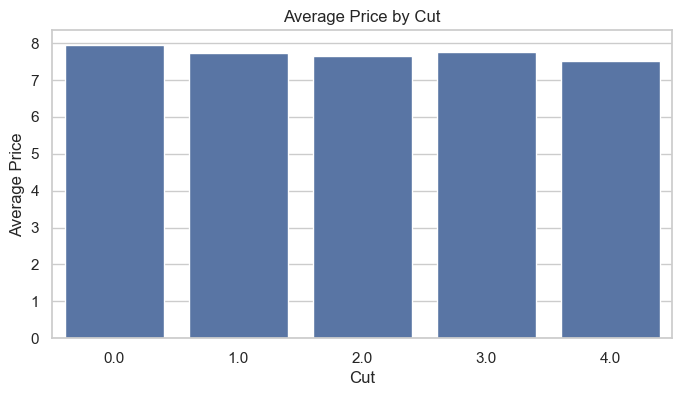

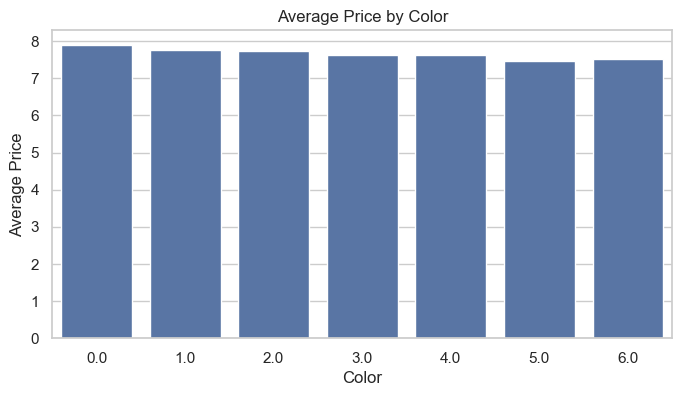

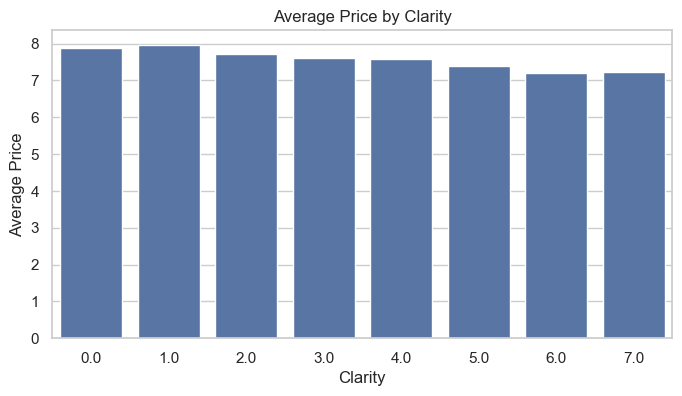

In [70]:
# 8. Average price per cut, color, clarity categories using bar plots
avg_price_cut = df.groupby('cut')['price'].mean().sort_index()
avg_price_color = df.groupby('color')['price'].mean().sort_index()
avg_price_clarity = df.groupby('clarity')['price'].mean().sort_index()

plt.figure(figsize=(8, 4))
sns.barplot(x=avg_price_cut.index, y=avg_price_cut.values)
plt.title('Average Price by Cut')
plt.xlabel('Cut')
plt.ylabel('Average Price')
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=avg_price_color.index, y=avg_price_color.values)
plt.title('Average Price by Color')
plt.xlabel('Color')
plt.ylabel('Average Price')
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=avg_price_clarity.index, y=avg_price_clarity.values)
plt.title('Average Price by Clarity')
plt.xlabel('Clarity')
plt.ylabel('Average Price')
plt.show()

In [72]:
# Correlation Matrix
numeric_cols_for_corr = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numeric_cols_for_corr].corr()
print("Correlation matrix calculated")

Correlation matrix calculated


In [74]:
# Random Forest Feature Importance
feature_cols = ['carat', 'depth', 'table', 'x', 'y', 'z', 'Volume', 'PricePerCarat', 'DimensionRatio', 'cut', 'color', 'clarity']
X_temp = df[feature_cols]
y_temp = df['price']

rf = RandomForestRegressor(random_state=1, n_estimators=50)
rf.fit(X_temp, y_temp)
importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
print("\nTop 5 Important Features:")
print(importances.sort_values(ascending=False).head())


Top 5 Important Features:
y          0.647859
carat      0.191945
Volume     0.084233
clarity    0.031065
x          0.017223
dtype: float64


In [76]:
# RFE - Select top 5 features
rfe = RFE(rf, n_features_to_select=5)
rfe.fit(X_temp, y_temp)
selected_features = list(X_temp.columns[rfe.support_])
print(f"\nRFE Selected Features: {selected_features}")


RFE Selected Features: ['carat', 'y', 'Volume', 'PricePerCarat', 'clarity']


In [79]:
# Use selected features for regression
features_final = selected_features  # Example: ['carat', 'y', 'Volume', 'PricePerCarat', 'clarity']

#SAVE REGRESSION FEATURES
with open('models/regression_features.pkl', 'wb') as f:
    pickle.dump(features_final, f)
print(f"Regression features saved: {features_final}")

Regression features saved: ['carat', 'y', 'Volume', 'PricePerCarat', 'clarity']


In [81]:
# Split data
X_final = df[features_final]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
print(f"✅ Train-test split: {X_train.shape}, {X_test.shape}")

✅ Train-test split: (39600, 5), (9901, 5)


In [83]:
# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

results = {}
predictions = {}

print("\n📊 Model Performance:")
print("="*60)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}
    print(f"{name:20s} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

print("="*60)


📊 Model Performance:
Linear Regression    | MAE: 0.1544 | RMSE: 0.1943 | R2: 0.9536
Decision Tree        | MAE: 0.0146 | RMSE: 0.0475 | R2: 0.9972
Random Forest        | MAE: 0.0106 | RMSE: 0.0340 | R2: 0.9986
KNN                  | MAE: 0.0524 | RMSE: 0.0847 | R2: 0.9912
XGBoost              | MAE: 0.0197 | RMSE: 0.0293 | R2: 0.9989


In [85]:
# Find best model (lowest RMSE)
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"    MAE:  {results[best_model_name]['MAE']:.4f}")
print(f"    RMSE: {results[best_model_name]['RMSE']:.4f}")
print(f"    R²:   {results[best_model_name]['R2']:.4f}")


🏆 Best Model: XGBoost
    MAE:  0.0197
    RMSE: 0.0293
    R²:   0.9989


In [87]:
# Save best model
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("✅ Best model saved as models/best_model.pkl")

✅ Best model saved as models/best_model.pkl


In [92]:
# ANN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

ann = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1)
])
ann.compile(optimizer='adam', loss='mse')
ann.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

y_pred_ann = ann.predict(X_test).flatten()
mae_ann = mean_absolute_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
r2_ann = r2_score(y_test, y_pred_ann)

results['ANN'] = {'MAE': mae_ann, 'MSE': mean_squared_error(y_test, y_pred_ann), 'RMSE': rmse_ann, 'R2': r2_ann}
print(f"ANN: RMSE={rmse_ann:.4f}, R2={r2_ann:.4f}")

# Save ANN model
ann.save('models/ann_model.h5')

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


ANN: RMSE=0.0563, R2=0.9961


In [91]:
!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/331.9 MB 479.2 kB/s eta 0:11:32
   ---------------------------------------- 0.5/331.9 MB 479.2 kB/s eta 0:11:32
   ---------------------------------------- 0.5/331.9 MB 479.2 kB/s eta 0:11:32
   ---------------------------------------- 0.5/331.9 MB 479.2 kB/s eta 0:11:32
   ---------------------------------------- 0.5/331.9 MB 479.2 kB/s eta 0:11:32
   ----------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [94]:
# Prepare clustering data (drop price columns)
cluster_df = df.drop(columns=['price', 'price_inr', 'CaratCategory'], errors='ignore')
cluster_df = cluster_df.select_dtypes(include=[np.number])

print(f"Clustering features: {cluster_df.columns.tolist()}")
print(f"Clustering data shape: {cluster_df.shape}")


Clustering features: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'Volume', 'PricePerCarat', 'DimensionRatio']
Clustering data shape: (49501, 12)


In [96]:
#SAVE CLUSTER COLUMNS
cluster_columns = cluster_df.columns.tolist()
with open('models/cluster_columns.pkl', 'wb') as f:
    pickle.dump(cluster_columns, f)
print(f"✅ Cluster columns saved ({len(cluster_columns)} features)")

✅ Cluster columns saved (12 features)


In [98]:
# Scale data for clustering
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)
print("Data scaled for clustering")

Data scaled for clustering


In [100]:
#SAVE SCALER (for clustering)
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved")

Scaler saved


In [102]:
# Elbow Method and Silhouette Score
print("\nFinding Optimal Number of Clusters...")
sse = []
silhouette = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(cluster_scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(cluster_scaled, labels))
    print(f"  k={k}: SSE={kmeans.inertia_:.2f}, Silhouette={silhouette[-1]:.4f}")


Finding Optimal Number of Clusters...
  k=2: SSE=333502.89, Silhouette=0.3738
  k=3: SSE=292117.03, Silhouette=0.2287
  k=4: SSE=265356.37, Silhouette=0.2154
  k=5: SSE=241629.27, Silhouette=0.2155
  k=6: SSE=225810.68, Silhouette=0.1897
  k=7: SSE=212127.50, Silhouette=0.2018
  k=8: SSE=202497.87, Silhouette=0.1783
  k=9: SSE=193273.76, Silhouette=0.1607
  k=10: SSE=185600.84, Silhouette=0.1624


In [103]:
# Choose best k (example: k=3)
best_k = 3
print(f"\n🏆 Selected k={best_k} clusters")


🏆 Selected k=3 clusters


In [106]:
# Train final KMeans model
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(cluster_scaled)

In [108]:
# Save clustering model
with open('models/cluster_model.pkl', 'wb') as f:
    pickle.dump(kmeans_final, f)
print("✅ Clustering model saved")

✅ Clustering model saved


In [110]:
# Add clusters to dataframe
df['cluster'] = cluster_labels

In [112]:
# Calculate cluster statistics
cluster_summary = df.groupby('cluster').agg({
    'price': 'mean',
    'carat': 'mean',
    'cut': lambda x: x.mode()[0],
    'color': lambda x: x.mode()[0],
    'clarity': lambda x: x.mode()[0],
    'cluster': 'count'
}).rename(columns={'cluster': 'count'})

print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
            price     carat  cut  color  clarity  count
cluster                                                
0        6.626465  0.291914  4.0    3.0      3.0  16771
1        8.595107  0.746400  3.0    3.0      2.0  18116
2        7.586932  0.478071  4.0    5.0      2.0  14614


In [114]:
# Naming logic
labels = []
for idx, row in cluster_summary.iterrows():
    carat_orig = np.expm1(row['carat'])
    price_orig = np.expm1(row['price'])
    
    if carat_orig > 1.2 and price_orig > 8000:
        labels.append('Premium Heavy Diamonds')
    elif carat_orig < 0.5 and price_orig < 2000:
        labels.append('Affordable Small Diamonds')
    else:
        labels.append('Mid-range Balanced Diamonds')

cluster_summary['Cluster_Name'] = labels

print("\nNamed Clusters:")
print(cluster_summary[['count', 'Cluster_Name']])


Named Clusters:
         count                 Cluster_Name
cluster                                    
0        16771    Affordable Small Diamonds
1        18116  Mid-range Balanced Diamonds
2        14614  Mid-range Balanced Diamonds


In [116]:
#SAVE CLUSTER NAMES
CLUSTER_NAMES = dict(zip(cluster_summary.index, cluster_summary['Cluster_Name']))
with open('models/cluster_names.pkl', 'wb') as f:
    pickle.dump(CLUSTER_NAMES, f)
print("Cluster names saved")
print(CLUSTER_NAMES)

Cluster names saved
{0: 'Affordable Small Diamonds', 1: 'Mid-range Balanced Diamonds', 2: 'Mid-range Balanced Diamonds'}


In [118]:
print("\n" + "="*60)
print("📂 VERIFYING ALL SAVED FILES")
print("="*60)

required_files = [
    'models/best_model.pkl',
    'models/cluster_model.pkl',
    'models/scaler.pkl',
    'models/encoder.pkl',
    'models/mean_price_per_carat.pkl',
    'models/cluster_columns.pkl',
    'models/regression_features.pkl',
    'models/cluster_names.pkl'
]

all_exist = True
for file in required_files:
    if os.path.exists(file):
        size = os.path.getsize(file)
        print(f"✅ {file:40s} - {size:>8} bytes")
    else:
        print(f"❌ {file:40s} - MISSING!")
        all_exist = False

print("="*60)

if all_exist:
    print("✅ ALL FILES SAVED SUCCESSFULLY!")
    print("\n🚀 Ready for Streamlit deployment!")
else:
    print("❌ Some files are missing. Please check the code.")

print("\n📊 METADATA SUMMARY:")
print("="*60)

with open('models/regression_features.pkl', 'rb') as f:
    reg_features = pickle.load(f)
print(f"Regression Features ({len(reg_features)}): {reg_features}")

with open('models/cluster_columns.pkl', 'rb') as f:
    cluster_cols = pickle.load(f)
print(f"Cluster Columns ({len(cluster_cols)}): {cluster_cols}")

with open('models/mean_price_per_carat.pkl', 'rb') as f:
    mean_ppc = pickle.load(f)
print(f"Mean PricePerCarat: {mean_ppc:.4f}")

with open('models/cluster_names.pkl', 'rb') as f:
    cluster_names_loaded = pickle.load(f)
print("\nCluster Names:")
for k, v in cluster_names_loaded.items():
    print(f"  Cluster {k}: {v}")

print("="*60)
print("✅ PROJECT COMPLETE!")


📂 VERIFYING ALL SAVED FILES
✅ models/best_model.pkl                    -   453143 bytes
✅ models/cluster_model.pkl                 -   198905 bytes
✅ models/scaler.pkl                        -      926 bytes
✅ models/encoder.pkl                       -      775 bytes
✅ models/mean_price_per_carat.pkl          -      116 bytes
✅ models/cluster_columns.pkl               -      118 bytes
✅ models/regression_features.pkl           -       63 bytes
✅ models/cluster_names.pkl                 -       82 bytes
✅ ALL FILES SAVED SUCCESSFULLY!

🚀 Ready for Streamlit deployment!

📊 METADATA SUMMARY:
Regression Features (5): ['carat', 'y', 'Volume', 'PricePerCarat', 'clarity']
Cluster Columns (12): ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'Volume', 'PricePerCarat', 'DimensionRatio']
Mean PricePerCarat: 16.8115

Cluster Names:
  Cluster 0: Affordable Small Diamonds
  Cluster 1: Mid-range Balanced Diamonds
  Cluster 2: Mid-range Balanced Diamonds
✅ PROJECT COMPLETE!


In [120]:
# Manual test mapping (just for testing)
CLUSTER_NAMES = {
    0: 'Affordable Small Diamonds',
    1: 'Mid-range Balanced Diamonds',
    2: 'Premium Heavy Diamonds'
}

# Save
with open('models/cluster_names.pkl', 'wb') as f:
    pickle.dump(CLUSTER_NAMES, f)

In [126]:
%%writefile app.py

# ============================================================
# DIAMOND DYNAMICS - STREAMLIT APP (FIXED VERSION)
# Price Prediction & Market Segmentation
# ============================================================

import streamlit as st
import pandas as pd
import numpy as np
import pickle

# ============================================================
# PAGE CONFIGURATION
# ============================================================

st.set_page_config(
    page_title="Diamond Dynamics",
    page_icon="💎",
    layout="wide",
    initial_sidebar_state="expanded"
)

# ============================================================
# LOAD ALL MODELS AND METADATA
# ============================================================

@st.cache_resource
def load_models():
    """Load all saved models and metadata"""
    try:
        with open('models/best_model.pkl', 'rb') as f:
            reg_model = pickle.load(f)
        
        with open('models/cluster_model.pkl', 'rb') as f:
            cluster_model = pickle.load(f)
        
        with open('models/scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        
        with open('models/mean_price_per_carat.pkl', 'rb') as f:
            mean_price_per_carat = pickle.load(f)
        
        with open('models/cluster_columns.pkl', 'rb') as f:
            cluster_columns = pickle.load(f)
        
        with open('models/regression_features.pkl', 'rb') as f:
            regression_features = pickle.load(f)
        
        with open('models/cluster_names.pkl', 'rb') as f:
            cluster_names = pickle.load(f)
        
        return (reg_model, cluster_model, scaler, mean_price_per_carat, 
                cluster_columns, regression_features, cluster_names)
    
    except Exception as e:
        st.error(f"❌ Error loading models: {e}")
        st.stop()

# Load models
(reg_model, cluster_model, scaler, mean_ppc, 
 cluster_cols, reg_features, CLUSTER_NAMES) = load_models()

st.success("✅ Models loaded successfully!")

# ============================================================
# MAIN UI
# ============================================================

st.title("💎 Diamond Dynamics: Price Prediction & Market Segmentation")
st.markdown("**Predict diamond prices and identify market segments using Machine Learning**")

# ============================================================
# SIDEBAR - USER INPUTS
# ============================================================

st.sidebar.header("📝 Enter Diamond Features")
st.sidebar.markdown("Fill in the diamond characteristics below:")

# Numeric Inputs
carat = st.sidebar.number_input("Carat", min_value=0.2, max_value=5.0, value=1.0, step=0.01, help="Weight of the diamond")
depth = st.sidebar.number_input("Depth %", min_value=50.0, max_value=70.0, value=61.0, step=0.1, help="Depth percentage")
table = st.sidebar.number_input("Table %", min_value=50.0, max_value=70.0, value=57.0, step=0.1, help="Table percentage")
x = st.sidebar.number_input("Length (x) mm", min_value=0.0, max_value=10.0, value=5.0, step=0.1, help="Length in mm")
y = st.sidebar.number_input("Width (y) mm", min_value=0.0, max_value=10.0, value=5.0, step=0.1, help="Width in mm")
z = st.sidebar.number_input("Height (z) mm", min_value=0.0, max_value=10.0, value=3.0, step=0.1, help="Height in mm")

# Categorical Inputs
cut = st.sidebar.selectbox("Cut", ["Fair", "Good", "Very Good", "Premium", "Ideal"], index=4)
color = st.sidebar.selectbox("Color", ["J", "I", "H", "G", "F", "E", "D"], index=3)
clarity = st.sidebar.selectbox("Clarity", ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"], index=4)

# Encoding mappings (matching your OrdinalEncoder order)
cut_mapping = {"Fair": 0, "Good": 1, "Very Good": 2, "Premium": 3, "Ideal": 4}
color_mapping = {"J": 0, "I": 1, "H": 2, "G": 3, "F": 4, "E": 5, "D": 6}
clarity_mapping = {"I1": 0, "SI2": 1, "SI1": 2, "VS2": 3, "VS1": 4, "VVS2": 5, "VVS1": 6, "IF": 7}

cut_encoded = cut_mapping[cut]
color_encoded = color_mapping[color]
clarity_encoded = clarity_mapping[clarity]

# ============================================================
# MODULE SELECTION
# ============================================================

st.markdown("---")
st.header("🔍 Choose Module:")

module = st.radio(
    "",
    ["💰 Price Prediction", "🍀 Market Segment Prediction"],
    horizontal=True
)

# ============================================================
# MODULE 1: PRICE PREDICTION
# ============================================================

if module == "💰 Price Prediction":
    st.subheader("💰 Predict Diamond Price (INR)")
    st.markdown("Get an estimated price for your diamond based on its features.")
    
    col1, col2 = st.columns([2, 1])
    
    with col1:
        if st.button("🔮 Predict Price", type="primary", use_container_width=True):
            try:
                # Step 1: Log transformation (as done during training)
                carat_log = np.log1p(carat)
                x_log = np.log1p(x)
                y_log = np.log1p(y)
                z_log = np.log1p(z)
                
                # Step 2: Create derived features
                Volume = x_log * y_log * z_log
                PricePerCarat = mean_ppc  # Use training mean
                DimensionRatio = (x_log + y_log) / (2 * z_log) if z_log != 0 else 0
                
                # Step 3: Build feature dictionary
                feature_dict = {
                    'carat': carat_log,
                    'x': x_log,
                    'y': y_log,
                    'z': z_log,
                    'depth': depth,
                    'table': table,
                    'cut': cut_encoded,
                    'color': color_encoded,
                    'clarity': clarity_encoded,
                    'Volume': Volume,
                    'PricePerCarat': PricePerCarat,
                    'DimensionRatio': DimensionRatio
                }
                
                # Step 4: Create input DataFrame with only the features your model needs
                input_data = pd.DataFrame({
                    feature: [feature_dict[feature]] 
                    for feature in reg_features
                })
                
                # Debug: Show what features we're using
                with st.expander("🐛 Debug Information"):
                    st.write(f"**Expected features:** {reg_features}")
                    st.write(f"**Input data columns:** {input_data.columns.tolist()}")
                    st.write(f"**Input data shape:** {input_data.shape}")
                    st.write(f"**Input values:**")
                    st.dataframe(input_data)
                
                # Step 5: Predict
                predicted_price_log = reg_model.predict(input_data)[0]
                
                # Step 6: Inverse log transformation
                predicted_price_usd = np.expm1(predicted_price_log)
                
                # Step 7: Convert to INR
                usd_to_inr = 83.0
                predicted_price_inr = predicted_price_usd * usd_to_inr
                
                # Display results
                st.success(f"✅ **Predicted Diamond Price: ₹{predicted_price_inr:,.2f} INR**")
                st.info(f"💵 Equivalent to ${predicted_price_usd:,.2f} USD")
                
                # Show input summary
                with st.expander("📋 Input Summary"):
                    st.write(f"**Carat:** {carat} | **Cut:** {cut} | **Color:** {color} | **Clarity:** {clarity}")
                    st.write(f"**Dimensions:** {x} × {y} × {z} mm")
                    st.write(f"**Depth:** {depth}% | **Table:** {table}%")
                
            except Exception as e:
                st.error(f"❌ Prediction Error: {e}")
                with st.expander("🐛 Debug Information"):
                    st.write(f"**Error:** {str(e)}")
                    st.write(f"**Expected features:** {reg_features}")
                    st.write(f"**Feature dict keys:** {list(feature_dict.keys())}")
    
    with col2:
        st.info("💡 **Tip:** Adjust the diamond features in the sidebar to see different price estimates.")

# ============================================================
# MODULE 2: MARKET SEGMENT PREDICTION
# ============================================================

elif module == "🍀 Market Segment Prediction":
    st.subheader("🍀 Predict Market Segment (Clustering)")
    st.markdown("Identify which market segment your diamond belongs to.")
    
    col1, col2 = st.columns([2, 1])
    
    with col1:
        if st.button("🔮 Predict Segment", type="primary", use_container_width=True):
            try:
                # Step 1: Log transformation
                carat_log = np.log1p(carat)
                x_log = np.log1p(x)
                y_log = np.log1p(y)
                z_log = np.log1p(z)
                
                # Step 2: Create derived features
                Volume = x_log * y_log * z_log
                DimensionRatio = (x_log + y_log) / (2 * z_log) if z_log != 0 else 0
                PricePerCarat = mean_ppc
                
                # Step 3: Build feature dictionary
                feature_dict = {
                    'carat': carat_log,
                    'x': x_log,
                    'y': y_log,
                    'z': z_log,
                    'depth': depth,
                    'table': table,
                    'cut': cut_encoded,
                    'color': color_encoded,
                    'clarity': clarity_encoded,
                    'Volume': Volume,
                    'PricePerCarat': PricePerCarat,
                    'DimensionRatio': DimensionRatio
                }
                
                # Step 4: Create input DataFrame with ALL cluster features
                cluster_input = pd.DataFrame({
                    col: [feature_dict[col]] 
                    for col in cluster_cols
                })
                
                # Debug: Show what features we're using
                with st.expander("🐛 Debug Information"):
                    st.write(f"**Expected features:** {cluster_cols}")
                    st.write(f"**Input data columns:** {cluster_input.columns.tolist()}")
                    st.write(f"**Input data shape:** {cluster_input.shape}")
                    st.write(f"**Input values:**")
                    st.dataframe(cluster_input)
                
                # Step 5: Scale the input
                cluster_input_scaled = scaler.transform(cluster_input)
                
                # Step 6: Predict cluster
                cluster_label = cluster_model.predict(cluster_input_scaled)[0]
                cluster_name = CLUSTER_NAMES.get(cluster_label, f"Cluster {cluster_label}")
                
                # Display results
                st.success(f"✅ **Market Segment: {cluster_name}**")
                st.info(f"🏷️ Cluster Number: {cluster_label}")
                
                # Show segment description
                segment_descriptions = {
                    "Premium Heavy Diamonds": "🌟 High-value diamonds with larger carat weight and superior quality.",
                    "Affordable Small Diamonds": "💎 Budget-friendly diamonds perfect for everyday jewelry.",
                    "Mid-range Balanced Diamonds": "⚖️ Well-balanced diamonds offering good value for money."
                }
                
                if cluster_name in segment_descriptions:
                    st.markdown(f"**Description:** {segment_descriptions[cluster_name]}")
                
                # Show input summary
                with st.expander("📋 Input Summary"):
                    st.write(f"**Carat:** {carat} | **Cut:** {cut} | **Color:** {color} | **Clarity:** {clarity}")
                    st.write(f"**Dimensions:** {x} × {y} × {z} mm")
                    st.write(f"**Depth:** {depth}% | **Table:** {table}%")
                
            except Exception as e:
                st.error(f"❌ Clustering Error: {e}")
                with st.expander("🐛 Debug Information"):
                    st.write(f"**Error:** {str(e)}")
                    st.write(f"**Expected features:** {cluster_cols}")
                    st.write(f"**Feature dict keys:** {list(feature_dict.keys())}")
    
    with col2:
        st.info("💡 **Tip:** Market segments help you understand your diamond's positioning in the market.")

# ============================================================
# FOOTER
# ============================================================

st.markdown("---")
st.markdown("""
<div style='text-align: center; color: gray;'>
    <p>💎 <b>Diamond Dynamics</b> - ML-Powered Diamond Analysis</p>
    <p>Built with Streamlit • Powered by Scikit-learn & XGBoost</p>
</div>
""", unsafe_allow_html=True)

Overwriting app.py


In [128]:
!streamlit run app.py

^C
